In [109]:
import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version in torch:", torch.version.cuda)
print("Is torch built with CUDA:", torch.backends.cuda.is_built())


Torch version: 2.4.1+cpu
CUDA available: False
CUDA version in torch: None
Is torch built with CUDA: False


In [110]:
device = "cpu"

import numpy as np
import torch.nn as nn
import torch.nn.functional as F


In [111]:
import json

with open("../tokenizer_data/vocab.json", "r", encoding="utf-8") as f:
    vocab = json.load(f)

vocab_size = len(vocab)
print("Vocabulary size:", vocab_size)


Vocabulary size: 2439


In [112]:
class DataLoader:
    def __init__(self, memmap_path: str, block_size: int, dtype = np.int32, start=0, end=None):
        self.tokens =  np.memmap(memmap_path, dtype=dtype, mode='r')
        self.block_size = block_size
        self.total_tokens = len(self.tokens)

        self.end = len(self.tokens) - block_size if end is None else end
        self.start = start
        self.length = self.end - self.start


    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        idx += self.start
        if idx + self.block_size + 1 > self.end:
            raise IndexError("Index out of bounds.")
        block = self.tokens[idx : idx + self.block_size + 1]
        x = torch.tensor(block[:-1], dtype=torch.long)
        y = torch.tensor(block[1:], dtype=torch.long)
        return x, y

    def get_batch(self, batch_size: int, device='cpu'):
        idxs = np.random.randint(0, self.length, size=batch_size)
        x_list, y_list = zip(*[self[i] for i in idxs])
        x = torch.stack(x_list).to(device)
        y = torch.stack(y_list).to(device)
        return x, y

    @staticmethod
    def collate_fn(batch):
        x = torch.stack([item[0] for item in batch])
        y = torch.stack([item[1] for item in batch])
        return x, y

In [113]:
train_batch_size = 16  # training batch size
eval_batch_size = 8  # evaluation batch size
context_length = 256  # number of tokens processed in a single batch
block_size = 256
train_split = 0.9  # percentage of data to use from total data for training
number_of_heads = 8
number_of_layers = 6


In [114]:
flattened = np.memmap(
    "../tokenized_sql_dataset/flatten_token.memmap",
    dtype=np.int32,
    mode="r"
)

In [115]:
usable_tokens = len(flattened) - block_size
split_ratio = 0.9
split_index = int(usable_tokens * split_ratio)

In [116]:
memmap_path = "../tokenized_sql_dataset/flatten_token.memmap"

train_loader = DataLoader(
        memmap_path=memmap_path,
        block_size=block_size,
        dtype=np.int32,
        start=0,
        end=split_index
    )

eval_loader = DataLoader(
        memmap_path=memmap_path,
        block_size=block_size,
        dtype=np.int32,
        start=split_index,
        end=usable_tokens  # to avoid index errors
    )


In [117]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, context_length, d_model):
        super().__init__()
        self.register_buffer("pe", self._build_pe(context_length, d_model))

    def _build_pe(self, length, d_model):
        position = torch.arange(0, length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe = torch.zeros(length, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)  # shape: [1, length, d_model]

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]




In [118]:
# class MultiHeadAttention(nn.Module):
#     def __init__(self, d_model: int, n_heads: int):
#         super().__init__()
        
#         self.n_heads = n_heads
#         self.head_dim = d_model // n_heads

#         assert (n_heads * self.head_dim == d_model)

#         self.query = nn.Linear(d_model, d_model)
#         self.key = nn.Linear(d_model, d_model)
#         self.value = nn.Linear(d_model, d_model)
#         self.fc_out = nn.Linear(d_model, d_model)
#         self.dropout = nn.Dropout(0.2)

#     def forward(self, inputs: torch.Tensor):
#         B, seq_length, d_model = inputs.shape
        
#         # Project the input embeddings into Q, K, and V
#         Q = self.query(inputs).view(B, seq_length, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
#         K = self.key(inputs).view(B, seq_length, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
#         V = self.value(inputs).view(B, seq_length, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
#         # Compute attention scores
#         attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)
        
#         # Apply mask to prevent attention to future tokens
#         mask = torch.triu(torch.ones(seq_length, seq_length), diagonal=1).bool().to(inputs.device)
#         attention_scores = attention_scores.masked_fill(mask, float('-inf'))
        
#         attention_weights = torch.softmax(attention_scores, dim=-1)
#         # Compute the weighted sum of the values
#         attention_output = torch.matmul(self.dropout(attention_weights), V)

#         # Concatenate heads and put them back to the original shape
#         attention_output = attention_output.permute(0, 2, 1, 3).contiguous()
#         attention_output = attention_output.view(B, seq_length, d_model)

#         # Apply the final linear transformation
#         out = self.fc_out(attention_output)
        
#         return out
    
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        self.qkv_proj = nn.Linear(d_model, 3 * d_model)
        self.fc_out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        B, T, C = x.shape
        qkv = self.qkv_proj(x)
        q, k, v = qkv.chunk(3, dim=-1)

        # Reshape for heads
        q = q.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)

        # Scaled dot-product attention
        attn_scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, float("-inf"))
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_output = attn_weights @ v

        attn_output = attn_output.transpose(1, 2).contiguous().view(B, T, C)
        return self.fc_out(self.dropout(attn_output))


In [119]:
class GPTBlock(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.GELU(),
            nn.Linear(4 * d_model, d_model),
            nn.Dropout(dropout)
        )

    def forward(self, x, mask):
        x = x + self.attn(self.ln1(x), mask)
        x = x + self.mlp(self.ln2(x))
        return x


In [120]:
# class GPT(nn.Module):
#     def __init__(self, vocab_size, d_model):
#         super().__init__()
#         self.wte = nn.Embedding(vocab_size, d_model) # word token embeddings
#         self.wpe = PositionalEncoding(context_length, d_model)

#         self.blocks = nn.ModuleList([GPTBlock(d_model, number_of_heads) for _ in  range(number_of_layers)])


#         self.lm_head = nn.Linear(d_model, vocab_size)
#         self.wte.weight = self.lm_head.weight

    
#     def forward(self, inputs, targets=None):
#         x = self.wte(inputs)                                   # [B, T, d_model]
#         logits = self.wpe(x)                                   # add positional encoding
#         for block in self.blocks:
#             logits = block(logits)        
#         logits = self.lm_head(logits)                               # [B, T, vocab_size]

#         loss = None
#         if targets is not None:
#             B, T, V = logits.shape
#             logits = logits.view(B * T, V)                     # flatten for CE
#             targets = targets.view(B * T)
#             loss = F.cross_entropy(logits, targets)
#         return logits, loss
    
#     def generate(self, inputs, max_new_tokens):
#         # this will store the model outputs along with the initial input sequence
#         # make a copy so that it doesn't interfare with model
#         for _ in range(max_new_tokens):
#             # we only pass targets on training to calculate loss
#             logits, _ = self(inputs)
#             # for all the batches, get the embeds for last predicted sequence
#             logits = logits[:, -1, :]
#             probs = F.softmax(logits, dim=1)
#             # get the probable token based on the input probs
#             idx_next = torch.multinomial(probs, num_samples=1)

#             inputs = torch.cat([inputs, idx_next], dim=1)
#         # as the inputs has all model outputs + initial inputs, we can use it as final output
#         return inputs

In [121]:
class GPT(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, n_heads, context_length, dropout=0.1):
        super().__init__()
        self.context_length = context_length
        self.wte = nn.Embedding(vocab_size, d_model)
        self.wpe = PositionalEncoding(context_length, d_model)

        self.blocks = nn.ModuleList([
            GPTBlock(d_model, n_heads, dropout) for _ in range(n_layers)
        ])
        self.ln_f = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)
        self.lm_head.weight = self.wte.weight  # Weight tying

    def forward(self, x, targets=None):
        B, T = x.size()
        assert T <= self.context_length

        mask = torch.tril(torch.ones(T, T, device=x.device)).unsqueeze(0).unsqueeze(0)
        x = self.wte(x)
        x = self.wpe(x)

        for block in self.blocks:
            x = block(x, mask)

        x = self.ln_f(x)
        logits = self.lm_head(x)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.context_length:]
            logits, _ = self(idx_cond)
            probs = F.softmax(logits[:, -1, :], dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, next_token), dim=1)
        return idx

In [122]:
basic_model = GPT(vocab_size=2439, d_model=256, n_heads=number_of_heads, n_layers=number_of_layers, context_length=context_length).to(device)
lr = 1e-4
optimizer = torch.optim.AdamW(basic_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=lr*0.1)


In [123]:
from tqdm import trange, tqdm

epochs = 1000
eval_steps = 50  # perform evaluation every n steps

train_loss = {}

for ep in trange(epochs, desc="Training Epochs"):
    xb, yb = train_loader.get_batch(train_batch_size, device)

    logits, loss = basic_model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(basic_model.parameters(), max_norm=1)

    optimizer.step()
    scheduler.step()

    train_loss[ep] = loss.item()

    if ep % eval_steps == 0 or ep == epochs - 1:
        basic_model.eval()
        with torch.no_grad():
            xvb, yvb = eval_loader.get_batch(eval_batch_size, device)
            _, e_loss = basic_model(xvb, yvb)

            tqdm.write(f"Epoch: {ep}\ttrain_loss: {loss.item():.4f}\teval_loss: {e_loss.item():.4f}")
        basic_model.train()  # back to training mode


Training Epochs:   0%|          | 1/1000 [00:01<24:01,  1.44s/it]

Epoch: 0	train_loss: 191.7591	eval_loss: 181.7066


Training Epochs:   5%|▌         | 51/1000 [01:15<21:07,  1.34s/it]

Epoch: 50	train_loss: 33.5239	eval_loss: 33.5588


Training Epochs:  10%|█         | 101/1000 [02:16<19:32,  1.30s/it]

Epoch: 100	train_loss: 18.2769	eval_loss: 18.1802


Training Epochs:  15%|█▌        | 151/1000 [03:10<15:29,  1.09s/it]

Epoch: 150	train_loss: 13.1234	eval_loss: 13.0168


Training Epochs:  20%|██        | 201/1000 [03:58<14:43,  1.11s/it]

Epoch: 200	train_loss: 10.4700	eval_loss: 10.1542


Training Epochs:  25%|██▌       | 251/1000 [04:45<12:42,  1.02s/it]

Epoch: 250	train_loss: 8.5212	eval_loss: 8.8875


Training Epochs:  30%|███       | 301/1000 [05:32<10:52,  1.07it/s]

Epoch: 300	train_loss: 7.2972	eval_loss: 7.7967


Training Epochs:  35%|███▌      | 351/1000 [06:16<10:15,  1.05it/s]

Epoch: 350	train_loss: 6.7039	eval_loss: 7.0993


Training Epochs:  40%|████      | 401/1000 [07:01<09:19,  1.07it/s]

Epoch: 400	train_loss: 5.4614	eval_loss: 6.5425


Training Epochs:  45%|████▌     | 451/1000 [07:46<09:11,  1.00s/it]

Epoch: 450	train_loss: 5.1394	eval_loss: 5.9851


Training Epochs:  50%|█████     | 501/1000 [08:35<08:19,  1.00s/it]

Epoch: 500	train_loss: 4.6068	eval_loss: 5.4156


Training Epochs:  55%|█████▌    | 551/1000 [09:26<08:47,  1.18s/it]

Epoch: 550	train_loss: 4.6923	eval_loss: 5.2948


Training Epochs:  60%|██████    | 601/1000 [10:15<07:47,  1.17s/it]

Epoch: 600	train_loss: 4.3136	eval_loss: 4.7051


Training Epochs:  65%|██████▌   | 651/1000 [11:09<06:36,  1.14s/it]

Epoch: 650	train_loss: 3.5209	eval_loss: 4.7434


Training Epochs:  70%|███████   | 701/1000 [11:56<05:29,  1.10s/it]

Epoch: 700	train_loss: 3.7772	eval_loss: 4.7694


Training Epochs:  75%|███████▌  | 751/1000 [12:51<04:02,  1.03it/s]

Epoch: 750	train_loss: 3.8872	eval_loss: 4.2142


Training Epochs:  80%|████████  | 801/1000 [13:42<03:50,  1.16s/it]

Epoch: 800	train_loss: 3.7584	eval_loss: 4.1730


Training Epochs:  85%|████████▌ | 851/1000 [14:35<02:26,  1.02it/s]

Epoch: 850	train_loss: 3.6052	eval_loss: 4.4203


Training Epochs:  90%|█████████ | 901/1000 [15:23<01:36,  1.02it/s]

Epoch: 900	train_loss: 3.2269	eval_loss: 3.9873


Training Epochs:  95%|█████████▌| 951/1000 [16:19<00:56,  1.14s/it]

Epoch: 950	train_loss: 3.1535	eval_loss: 4.2367


Training Epochs: 100%|██████████| 1000/1000 [17:12<00:00,  1.03s/it]

Epoch: 999	train_loss: 2.8009	eval_loss: 3.7305


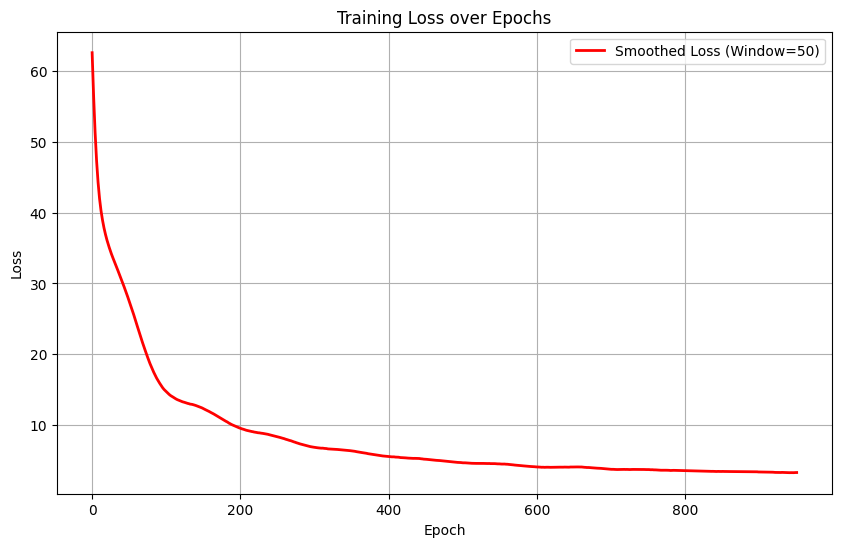

In [124]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming train_loss is your dictionary with epoch and loss
epochs = list(train_loss.keys())
losses = list(train_loss.values())

# Smoothing parameters
smooth_window = 50  # Adjust the window size for smoothing

# Smoothed losses using moving average
smoothed_losses = np.convolve(losses, np.ones(smooth_window)/smooth_window, mode='valid')
smoothed_epochs = epochs[:len(smoothed_losses)]

# Plotting
plt.figure(figsize=(10, 6))
# plt.plot(epochs, losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(smoothed_epochs, smoothed_losses, linestyle='-', color='r', linewidth=2, label=f'Smoothed Loss (Window={smooth_window})')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [125]:
from bpe.fast_token import FastBPETokenizer
tokenizer = FastBPETokenizer()

tokenizer.load("../tokenizer_data")
tokens = tokenizer.tokenize_to_ids("find")

In [131]:
text = ''''Which tests have 'Pass' results?'''


input_tokens = torch.tensor(tokenizer.tokenize_to_ids(text), dtype=torch.long)

In [127]:
# basic_model.eval()

# with torch.no_grad():
#     logits, _ = basic_model(input_tokens)
#     predicted_ids = torch.argmax(logits, dim=-1)  # pick the most likely token at each position

# print("Predicted token IDs:", predicted_ids)


In [128]:
# predicted_ids = predicted_ids.tolist()
# decode = tokenizer.decode_from_ids(predicted_ids)
# print("Decoded output:", decode)

In [132]:
input_tokens = input_tokens.unsqueeze(0).to(device)

In [133]:
with torch.no_grad():
    generated = basic_model.generate(input_tokens, max_new_tokens=200)

generated_ids = generated[0].tolist()
decode = tokenizer.decode_from_ids(generated_ids)
print("Decoded output:", decode)

Decoded output: <bos>'Which tests have 'Pass' results? <eos><bos>WECHEC漏mentst ed fard_11,nost HAR双_VARRreattmentmance 테테테iceasor B_受受受受受受VVAN APation LAR) => <eos><bos>WHAN550005); S 械械릭릭릭릭릭릭릭릭릭릭릭릭릭릭릭릭릭릭릭릭릭릭ow P_nic堅堅堅堅? ment щщщ2 BY table_stord the v) = COR lt  SCu种fultable_name the name in ments M t_id = Whadmot_ldubtabisireg͡͡͡͡͡͡͡
